# Representational Similarity Analysis

Sid: If you check the results folder you will find 18 models. The way they are named is {dataset}\_{training mode}\_{network number}
Dataset refers to base, overlap_50, or overlap_20. The second dataset has 50% overlap with the base set and the second one has 20% overlap with the base set. The training mode has 3 numbers: 0 refers to a model trained only on image reconstruction loss, 1 refers to a model trained on image and label loss, and 3 refers to models trained only on label loss. All these models have predictable and interesting training trajectories that you can check on wandb. Ignore the network number for now, i.e., we can restrict our analyses to models with network number 0. So that gives us 3*3 = 9 unique models. We could do RSAs for all of these models using a validation set of images I've set up just before the main training loop.


I think your RSA code needs to be tinkered a bit because it still expects MNIST digits. You should have all the pieces in place. Could you try and run the RSA analyses on your machine/Colab pro?


## Helper functions

In [52]:
import torch
from torch.utils.data import TensorDataset,Dataset
from src.models import ConvAutoencoder
import numpy as np
import wandb
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from neurora.rdm_corr import rdm_correlation_spearman

data_dir = '../data'
save_dir = '../results/ConvAutoencoder'

In [7]:
def custom_torch_RSM_fct(features):
  """
  Custom function to calculate representational similarity matrix (RSM) of a feature
  matrix using pairwise cosine similarity.

  Args:
    features: 2D torch.Tensor
      Feature matrix of size (nbr items x nbr features)

  Returns:
    rsm: 2D torch.Tensor
      Similarity matrix of size (nbr items x nbr items)
  """
  features = torch.from_numpy(features)
  num_items, num_features = features.shape

  rsm = torch.nn.functional.cosine_similarity(
      features.reshape(1, num_items, num_features),
      features.reshape(num_items, 1, num_features),
      dim=2
      )

  if not rsm.shape == (num_items, num_items):
    raise ValueError(
        f"RSM should be of shape ({num_items}, {num_items})"
        )
  return rsm

In [46]:
def wandb_rsm_init():
  wandb.init(project="ConceptualAlignmentLanguage", entity="psych-711")
  wandb.run.name = 'rsms'
  
def compute_rsms(save_dir, batch_size, latent_dims, num_classes, test_data, device='cpu'):
  '''
  Computes RSMs of all the models
  '''
  #all_rsms = torch.rand((len(os.listdir(save_dir)), 10000 ,10000))
  all_rsms = torch.rand((len(os.listdir(save_dir)), 4000 ,4000))
  print(all_rsms.shape)
  model_names = []
  print('Computing RSMs')
  for i, model in tqdm(enumerate(sorted(os.listdir(save_dir)))):
    model_names.append(model)
    autoencoder = ConvAutoencoder.ConvAutoencoder(latent_dims, num_classes, device).to(device) # GPU
    autoencoder.eval()
    autoencoder.load_state_dict(torch.load(os.path.join(save_dir, model)))
    autoencoder.eval()
    #initialise arrays
    latent_representations = np.asarray([[0,0,0,0,0,0,0,0,0,0]])
    labels = np.asarray([0])
    for image_batch, label_batch in test_data:
        image_batch = image_batch.to(device)
        label_batch_one_hot = F.one_hot(label_batch, num_classes=num_classes)
        label_batch_one_hot = label_batch_one_hot.to(device)
        z = autoencoder.encoder.forward(image_batch, label_batch_one_hot.float()) 
        latent_representations = np.vstack((latent_representations, z.cpu().detach()))
        labels = np.concatenate((labels, label_batch.float().cpu().detach()))
    labels = labels[1:]    
    latent_representations = latent_representations[1:]
    sorted_idx = np.array([], dtype = np.int8)

    for label_class in range(num_classes):
      sorted_idx = np.concatenate((sorted_idx, np.where(labels==label_class)[0]))
    latent_representations = latent_representations[sorted_idx]
    rsm = custom_torch_RSM_fct(latent_representations)
    all_rsms[i] = rsm
    plt.imshow(rsm)
    plt.colorbar()
    wandb.log({"RSM : {}".format(model): plt})
    plt.clf()
    print('Done with RSMs')
  return all_rsms, model_names


def fill_upper_triangular(matrix):
  '''
  Fills in the upper trinagular matrix for a symmetric matrix which has
  lower traingular matrix filled iin
  '''
  items, features = matrix.shape
  assert(items==features)
  for i in range(items):
    for j in range(i+1, items):
      matrix[i][j] = matrix[j][i]
  return matrix

def log_rsm(matrix, var_name):
  plt.imshow(matrix)
  plt.colorbar()
  wandb.log({var_name: plt})
  plt.clf()
  

def compute_rsa(all_rsms, model_names):
  '''
  Computes pairwise RSA (and significance) for all the models given their rsms
  '''
  rsa_corr = torch.zeros([len(model_names), len(model_names)])
  rsa_pvalue = torch.zeros([len(model_names), len(model_names)])

  # Computes the lower triangular matrix irst 
  print('Computing RSA)')
  for i in tqdm(range(len(model_names))):
    for j in range(i +1):
      rsa_corr[i][j],rsa_pvalue[i][j]= rdm_correlation_spearman(all_rsms[i], 
                                                                all_rsms[j], 
                                                                rescale=False,
                                                                permutation=False, iter=1000)
  # Fills in the upper triangular matrix
  print('Done with RSA')
  rsa_corr = fill_upper_triangular(rsa_corr)
  rsa_pvalue = fill_upper_triangular(rsa_pvalue)
  log_rsm(rsa_corr, "RSA corr")
  log_rsm(rsa_pvalue, "RSA pvalue")
  return rsa_corr, rsa_pvalue


def main_analysis_loop(save_dir, batch_size, latent_dims, num_classes, 
                       test_data):
  '''
  Takes in all the models in a saved dir and computes pairwise rsa
  '''
  wandb_rsm_init()
  all_rsms, model_names = compute_rsms(save_dir, batch_size, latent_dims, 
                                       num_classes, test_data)
  rsa_corr, rsa_pvalue = compute_rsa(all_rsms, model_names)
  rsa_corr, rsa_pvalue = fill_upper_triangular(rsa_corr), fill_upper_triangular(rsa_pvalue)
  return rsa_corr, rsa_pvalue, model_names


## Run RSM analysis

In [47]:
num_classes = 4 # Number of unique class labels in the dataset
latent_dims = 10
batch_size = 1024

In [53]:
# test_data = torch.utils.data.DataLoader( 
#       torchvision.datasets.MNIST('./data', 
#             transform=torchvision.transforms.ToTensor(),
#             download=True, train = False),
#       batch_size=batch_size,
#       shuffle=False)

### Load validation arrays
validation_ims = np.load(os.path.join(data_dir,'validation_set.npy'))
validation_labs = np.load(os.path.join(data_dir,'validation_labs.npy'))

test_data = TensorDataset(torch.tensor(validation_ims.transpose(0,3,1,2)/255).float(), torch.tensor(validation_labs).to(torch.int64))
test_data = torch.utils.data.DataLoader(test_data, 
                                                batch_size=batch_size,
                                              shuffle=False)

rsa_corr, rsa_pvalue, model_names = main_analysis_loop(save_dir, batch_size, latent_dims, num_classes, 
                       test_data)

torch.Size([9, 4000, 4000])
Computing RSMs


1it [00:02,  2.88s/it]

Done with RSMs


2it [00:05,  2.76s/it]

Done with RSMs


3it [00:07,  2.45s/it]

Done with RSMs


4it [00:09,  2.36s/it]

Done with RSMs


5it [00:12,  2.33s/it]

Done with RSMs


6it [00:14,  2.45s/it]

Done with RSMs


7it [00:16,  2.31s/it]

Done with RSMs


8it [00:18,  2.17s/it]

Done with RSMs


9it [00:20,  2.32s/it]


Done with RSMs
Computing RSA)


100%|██████████| 9/9 [15:52<00:00, 105.84s/it]

Done with RSA


<Figure size 432x288 with 0 Axes>

In [56]:
import pandas as pd
pd.DataFrame(rsa_corr, model_names, model_names)

,base_0_0,base_1_0,base_2_0,overlap_20_0_0,overlap_20_1_0,overlap_20_2_0,overlap_50_0_0,overlap_50_1_0,overlap_50_2_0
base_0_0,1.000000,0.115900,0.006092,0.677334,0.005734,0.007272,0.553246,0.028342,0.004931
base_1_0,0.115900,1.000000,0.513410,0.290788,0.476515,0.376019,0.380818,0.436629,0.408978
base_2_0,0.006092,0.513410,1.000000,0.016708,0.774750,0.654578,0.019353,0.525966,0.778052
overlap_20_0_0,0.677334,0.290788,0.016708,1.000000,0.016315,0.014645,0.826446,-0.005839,0.017096
overlap_20_1_0,0.005734,0.476515,0.774750,0.016315,1.000000,0.881378,0.013544,0.777030,0.918011
overlap_20_2_0,0.007272,0.376019,0.654578,0.014645,0.881378,1.000000,-0.000304,0.703908,0.914330
overlap_50_0_0,0.553246,0.380818,0.019353,0.826446,0.013544,-0.000304,1.000000,0.019200,0.004890
overlap_50_1_0,0.028342,0.436629,0.525966,-0.005839,0.777030,0.703908,0.019200,1.000000,0.677333
overlap_50_2_0,0.004931,0.408978,0.778052,0.017096,0.918011,0.914330,0.004890,0.677333,1.000000


In [55]:
model_names

['base_0_0',
 'base_1_0',
 'base_2_0',
 'overlap_20_0_0',
 'overlap_20_1_0',
 'overlap_20_2_0',
 'overlap_50_0_0',
 'overlap_50_1_0',
 'overlap_50_2_0']

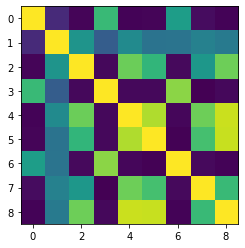

In [57]:
plt.imshow(rsa_corr)